In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pickle, os

In [50]:
dataset_name = "W16_only"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
           "BES_reduced",
#            "BESnumeric"
          ]

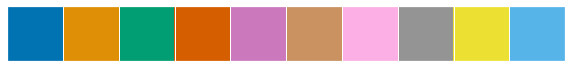

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [51]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [52]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (468, 13)


In [53]:
import warnings
warnings.simplefilter('ignore')

In [33]:
BES_Panel["euroElectionVote"].cat.categories

Index(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party', 'Other',
       'Change UK- The Independent Group', 'Brexit Party', 'Don't know'],
      dtype='object')

In [35]:
sample_sizes = BES_Panel["euroElectionVote"].value_counts().loc[BES_Panel["euroElectionVote"].cat.categories]

Conservative                                1716
Labour                                      2515
Liberal Democrat                            5392
Scottish National Party (SNP)                945
Plaid Cymru                                  294
United Kingdom Independence Party (UKIP)     399
Green Party                                 3543
Other                                        526
Change UK- The Independent Group             883
Brexit Party                                9243
Don't know                                   381
Name: euroElectionVote, dtype: int64

In [7]:
from cycler import cycler
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14, color=None, label=None, char_limit=40):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ids = ser1[mask].index
    ser1 = ser1[mask].cat.remove_unused_categories()
    ser2 = ser2[mask].cat.remove_unused_categories()
#     ct = pd.crosstab( ser1, ser2,
#                       values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(ids), aggfunc=sum, normalize=normalize)*100    
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index[ser2.value_counts().index>0])
    else:
        sample_sizes = ser2.value_counts().loc[ser2.cat.categories]
        sorted_labels = list(ser2.cat.categories[sample_sizes>0])
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)

#     hatch_cycle = cycler(hatch=['/', '*', '-','+','x','\\','o' '|'])
    # Define some hatches
#     hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(next(hatch_cycle))

    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title, char_limit = char_limit) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [54]:
pan_dataset_allr_values = pd.read_csv( BES_small_data_files + "pan_dataset_allr_values"+".csv" )

In [9]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)[mask]

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [10]:
def get_all_weights(ids, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel.loc[ids, list(num_to_weight.values())]
    else:
        wts = BES_Panel.loc[ids, specific_wave]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [11]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

IndexError: list index out of range

In [12]:
num_to_weight = {16:"wt_new_"}

In [25]:
search(BES_Panel,"wt_new_")

wt_new_              37959
wt_new_W1_            2427
wt_fresh_            18217
wt_new_W13           14647
wt_new_W13_result    14647
wt_new_W6             9587
wt_new_W2             8388
dtype: int64

In [ ]:
### Brexit Party prior vote?

In [69]:
search(BES_Panel,"like")

likeMay            37959
likeCorbyn         37959
likeCable          37959
likeSturgeon        3681
likePrice           2231
likeBatten         37959
likeFarage         37959
likeAllen          37959
likeBartley        18791
likeBerry          19168
likeCon            37959
likeLab            37959
likeLD             37959
likeSNP             3681
likePC              2231
likeUKIP           37959
likeGrn            37959
likeBrexitParty    37959
likeTIG            37959
dtype: int64

In [11]:
BES_Panel["euroElectionVote"].value_counts()

Brexit Party                                9243
Liberal Democrat                            5392
Green Party                                 3543
Labour                                      2515
Conservative                                1716
Scottish National Party (SNP)                945
Change UK- The Independent Group             883
Other                                        526
United Kingdom Independence Party (UKIP)     399
Don't know                                   381
Plaid Cymru                                  294
Name: euroElectionVote, dtype: int64

In [55]:
BES_Panel["euroElectionBXPVoter"] = BES_Panel["euroElectionVote"]=="Brexit Party"
BES_Panel.loc[BES_Panel["euroElectionVote"].isnull(),"euroElectionBXPVoter"]=np.nan
BES_Panel.loc[BES_Panel["euroElectionBXPVoter"]==True,"euroElectionBXPVoter"]="Yes"
BES_Panel.loc[BES_Panel["euroElectionBXPVoter"]==False,"euroElectionBXPVoter"]="No"
BES_Panel["euroElectionBXPVoter"] = BES_Panel["euroElectionBXPVoter"].astype('category')

In [30]:
BES_Panel["euroElectionBXPVoter"]

0        Yes
1         No
2         No
3        Yes
4         No
        ... 
37954    NaN
37955     No
37956     No
37957    NaN
37958    NaN
Name: euroElectionBXPVoter, Length: 37959, dtype: category
Categories (2, object): [No, Yes]

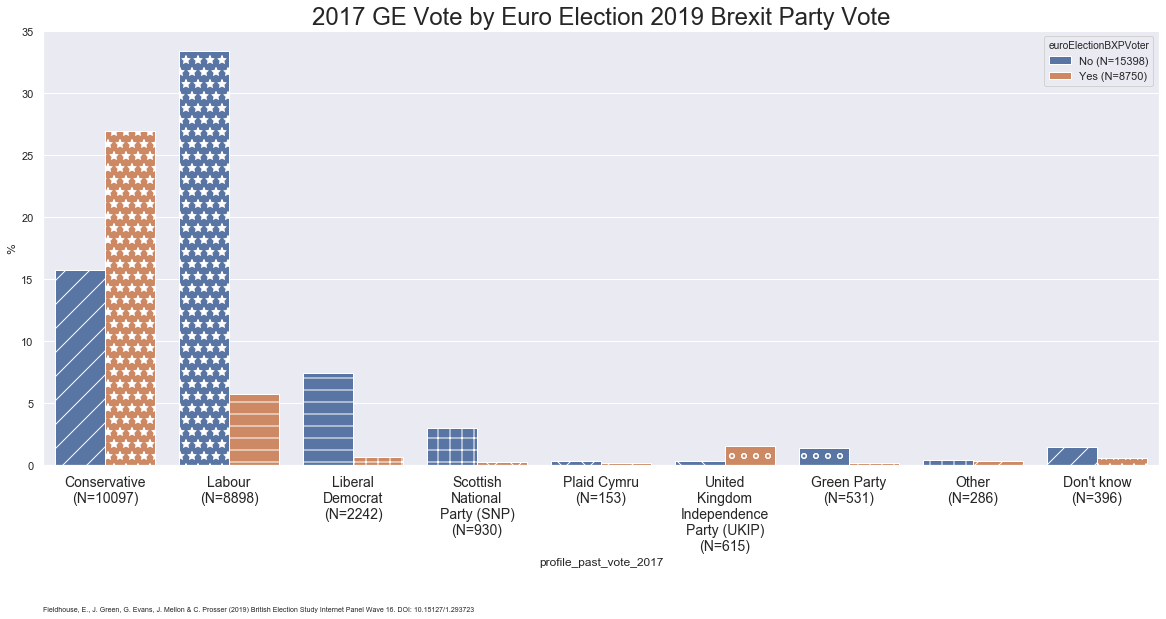

In [44]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 16

var2 ="profile_past_vote_2017"
var1 ="euroElectionBXPVoter"

# mask = ResidentInWales

# df2 = govtHandouts
df2 = BES_Panel[var2]#[mask]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]#[mask]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 12,
              title_fontsize=24,
              char_limit=120,
              title="2017 GE Vote by Euro Election 2019 Brexit Party Vote")
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [ ]:
### What predicts Brexit Party EE2019 voting?



0        1.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
37954    NaN
37955    0.0
37956    0.0
37957    NaN
37958    NaN
Name: euroElectionBXPVoter, Length: 37959, dtype: float64

In [56]:
BES_reduced_with_na["euroElectionBXPVoter_Yes"] = BES_Panel["euroElectionBXPVoter"].replace("Yes",1).replace("No",0)

In [18]:
# Treatment = "xgboost_dealVnodeal"
# var_stub = "dealVnodeal"

# var_list = ["dealVnodeal_Leave without a deal"]
# var_stub_list = [var_stub,"euRefVote_Leave the EU","euID_The leave side","dealVremain_Remain in the EU",
#                  "delayOrNoDeal_Delay Brexit until parliament can agree a deal","euRefDoOver_Yes","cancelBrexit__Strongly agree",
#                  "euRefpastVote_Leave the EU","pastvote_EURef_Leave the EU",
#                  "willOfPeople__Strongly agree","dealVnodeal_Leave without a deal","profile_eurefvote_Leave the EU",
#                  "regretsIHaveAFewEU__I did not vote", 'noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good',
#                  "remainVnodeal_Remain in the EU"]

Treatment = "xgboost_BXPEE2019Vote"
var_stub = "euroElection"
var_list = ["euroElectionBXPVoter_Yes"]
var_stub_list = [var_stub,"likeBrexitParty__Strongly like","generalElectionVote",
                 "bestOnMII_Brexit Party","ptvBrexitParty__Very likely","partyId_Brexit Party"]

# "likeBrexitParty__Strongly like","generalElectionVote_Brexit Party",
# "bestOnMII_Brexit Party","ptvBrexitParty__Very likely","generalElectionVote"

# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1
#     return (BES_Panel["country"]=="Wales")
#     return (BES_Panel["profile_eurefvote"]=='Stay/remain in the EU')
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
#     keep_list = search(BES_reduced_with_na,"speakWelsh|countryOfBirth|Mean_welshness|Mean_englishness|Mean_britishness|englishness_minus_welshness|britishness_minus_englishness|britishness_minus_welshness").index
#     keep_list = search(BES_reduced_with_na,"subjClass|ns_sec|socialgrade|anyUni|profile_education_age|subjectHE|edlevel|countryOfBirth|englishness|britishness|welshness|speakWelsh|profile_work_stat|workingStatus").index
    #BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.01,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:0.496169
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:0.492396
[2]	validation_0-rmse:0.488642
[3]	validation_0-rmse:0.484942
[4]	validation_0-rmse:0.481263
[5]	validation_0-rmse:0.477602
[6]	validation_0-rmse:0.474019
[7]	validation_0-rmse:0.470467
[8]	validation_0-rmse:0.467077
[9]	validation_0-rmse:0.46369
[10]	validation_0-rmse:0.460292
[11]	validation_0-rmse:0.456921
[12]	validation_0-rmse:0.453614
[13]	validation_0-rmse:0.450327
[14]	validation_0-rmse:0.447215
[15]	validation_0-rmse:0.443966
[16]	validation_0-rmse:0.44085
[17]	validation_0-rmse:0.437792
[18]	validation_0-rmse:0.434864
[19]	validation_0-rmse:0.431914
[20]	validation_0-rmse:0.428901
[21]	validation_0-rmse:0.426017
[22]	validation_0-rmse:0.423154
[23]	validation_0-rmse:0.420309
[24]	validation_0-rmse:0.417537
[25]	validation_0-rmse:0.414696
[26]	validation_0-rmse:0.412016
[27]	validation_0-rmse:0.409248
[28]	validation_0-rmse:0.406469
[29]	validation_

[251]	validation_0-rmse:0.224854
[252]	validation_0-rmse:0.224754
[253]	validation_0-rmse:0.224678
[254]	validation_0-rmse:0.224587
[255]	validation_0-rmse:0.224476
[256]	validation_0-rmse:0.22437
[257]	validation_0-rmse:0.224294
[258]	validation_0-rmse:0.224215
[259]	validation_0-rmse:0.224132
[260]	validation_0-rmse:0.224064
[261]	validation_0-rmse:0.223978
[262]	validation_0-rmse:0.223887
[263]	validation_0-rmse:0.22382
[264]	validation_0-rmse:0.223764
[265]	validation_0-rmse:0.223693
[266]	validation_0-rmse:0.223629
[267]	validation_0-rmse:0.22355
[268]	validation_0-rmse:0.223473
[269]	validation_0-rmse:0.223422
[270]	validation_0-rmse:0.223361
[271]	validation_0-rmse:0.223275
[272]	validation_0-rmse:0.223211
[273]	validation_0-rmse:0.223156
[274]	validation_0-rmse:0.223083
[275]	validation_0-rmse:0.223045
[276]	validation_0-rmse:0.222974
[277]	validation_0-rmse:0.222892
[278]	validation_0-rmse:0.222841
[279]	validation_0-rmse:0.222775
[280]	validation_0-rmse:0.22274
[281]	validati

[501]	validation_0-rmse:0.218254
[502]	validation_0-rmse:0.218245
[503]	validation_0-rmse:0.218236
[504]	validation_0-rmse:0.218228
[505]	validation_0-rmse:0.218212
[506]	validation_0-rmse:0.218198
[507]	validation_0-rmse:0.21819
[508]	validation_0-rmse:0.218191
[509]	validation_0-rmse:0.218178
[510]	validation_0-rmse:0.218185
[511]	validation_0-rmse:0.218177
[512]	validation_0-rmse:0.218167
[513]	validation_0-rmse:0.218165
[514]	validation_0-rmse:0.218167
[515]	validation_0-rmse:0.218166
[516]	validation_0-rmse:0.218166
[517]	validation_0-rmse:0.218166
[518]	validation_0-rmse:0.218162
[519]	validation_0-rmse:0.218146
[520]	validation_0-rmse:0.21815
[521]	validation_0-rmse:0.218138
[522]	validation_0-rmse:0.218128
[523]	validation_0-rmse:0.218131
[524]	validation_0-rmse:0.218125
[525]	validation_0-rmse:0.218123
[526]	validation_0-rmse:0.218124
[527]	validation_0-rmse:0.218128
[528]	validation_0-rmse:0.218126
[529]	validation_0-rmse:0.218115
[530]	validation_0-rmse:0.218097
[531]	valida

[751]	validation_0-rmse:0.217727
[752]	validation_0-rmse:0.217718
[753]	validation_0-rmse:0.217717
[754]	validation_0-rmse:0.217714
[755]	validation_0-rmse:0.217714
[756]	validation_0-rmse:0.217711
[757]	validation_0-rmse:0.21771
[758]	validation_0-rmse:0.217714
[759]	validation_0-rmse:0.217709
[760]	validation_0-rmse:0.217709
[761]	validation_0-rmse:0.21771
[762]	validation_0-rmse:0.217709
[763]	validation_0-rmse:0.217699
[764]	validation_0-rmse:0.217698
[765]	validation_0-rmse:0.217698
[766]	validation_0-rmse:0.217688
[767]	validation_0-rmse:0.21769
[768]	validation_0-rmse:0.21769
[769]	validation_0-rmse:0.217684
[770]	validation_0-rmse:0.217681
[771]	validation_0-rmse:0.217682
[772]	validation_0-rmse:0.217666
[773]	validation_0-rmse:0.217668
[774]	validation_0-rmse:0.217671
[775]	validation_0-rmse:0.217671
[776]	validation_0-rmse:0.217674
[777]	validation_0-rmse:0.217683
[778]	validation_0-rmse:0.217686
[779]	validation_0-rmse:0.217684
[780]	validation_0-rmse:0.217688
[781]	validati

[1001]	validation_0-rmse:0.217582
[1002]	validation_0-rmse:0.217588
[1003]	validation_0-rmse:0.217586
[1004]	validation_0-rmse:0.217581
[1005]	validation_0-rmse:0.217577
[1006]	validation_0-rmse:0.217586
[1007]	validation_0-rmse:0.217589
[1008]	validation_0-rmse:0.217588
[1009]	validation_0-rmse:0.217592
[1010]	validation_0-rmse:0.217592
[1011]	validation_0-rmse:0.217595
[1012]	validation_0-rmse:0.2176
[1013]	validation_0-rmse:0.217592
[1014]	validation_0-rmse:0.217589
[1015]	validation_0-rmse:0.217594
[1016]	validation_0-rmse:0.217593
[1017]	validation_0-rmse:0.21759
[1018]	validation_0-rmse:0.217595
[1019]	validation_0-rmse:0.217593
[1020]	validation_0-rmse:0.2176
[1021]	validation_0-rmse:0.217603
[1022]	validation_0-rmse:0.217594
[1023]	validation_0-rmse:0.217589
[1024]	validation_0-rmse:0.217593
[1025]	validation_0-rmse:0.217583
[1026]	validation_0-rmse:0.217583
[1027]	validation_0-rmse:0.217586
[1028]	validation_0-rmse:0.217592
[1029]	validation_0-rmse:0.217587
[1030]	validation_0

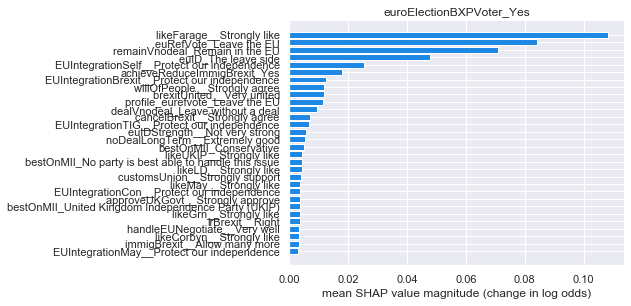

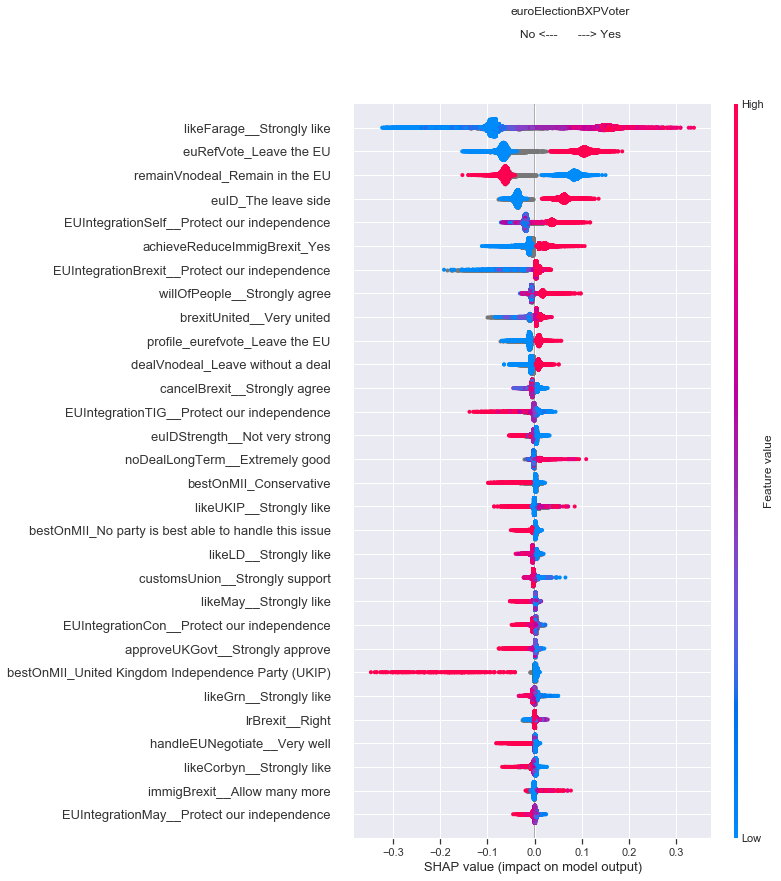

Wall time: 2h 22min 7s


(<shap.explainers.tree.TreeExplainer at 0x15dbb588>,
 array([[ 5.31676691e-03,  2.04903283e-03,  8.46271636e-04, ...,
          1.85560304e-04, -3.73578659e-04, -6.60060497e-04],
        [-1.51865999e-03, -4.19555639e-04,  9.14528500e-04, ...,
          3.34299148e-05, -9.05598790e-05,  7.39417854e-04],
        [-2.17679376e-03, -3.69282323e-03, -5.61409470e-05, ...,
          9.77946256e-05,  1.40825962e-03, -5.95027814e-05],
        ...,
        [-6.54807605e-04, -3.78940313e-04, -3.94271658e-04, ...,
          2.96858852e-05, -1.22803132e-04, -2.26186152e-04],
        [-1.54331978e-03, -5.52216719e-04, -1.76896306e-03, ...,
          4.71604108e-05, -1.02116144e-04,  3.73054552e-03],
        [ 1.97960883e-02,  2.20271177e-04,  2.87812465e-04, ...,
         -3.36674252e-03, -9.70344336e-05, -2.44555366e-03]], dtype=float32))

In [19]:
%%time
colname = "euroElectionBXPVoter"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,30),
           title = colname+"\n\nNo <---      ---> Yes")

In [ ]:
# "likeBrexitParty__Strongly like","generalElectionVote_Brexit Party",
# "bestOnMII_Brexit Party","ptvBrexitParty__Very likely","generalElectionVote","partyId_Brexit Party"

In [66]:
#### Correlation
search(BES_reduced_with_na,"euroElection")

euroElectionVote_Brexit Party                                        24930
euroElectionVote_Liberal Democrat                                    24930
euroElectionVote_Green Party                                         24930
euroElectionVote_Labour                                              24930
euroElectionVote_Conservative                                        24930
euroElectionVote_Scottish National Party (SNP)                       24930
euroElectionVote_Change UK- The Independent Group                    24930
euroElectionVote_United Kingdom Independence Party (UKIP)            24930
euroElectionVote_Plaid Cymru                                         24930
euroElectionVoteNonVoter_Brexit Party                                 6993
euroElectionVoteNonVoter_Labour                                       6993
euroElectionVoteNonVoter_Conservative                                 6993
euroElectionVoteNonVoter_Liberal Democrat                             6993
euroElectionVoteNonVoter_

In [68]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "euroElectionVote|euroElectionBXPVoter_Yes|euroElectionVote_Brexit Party"
name = "euroElectionBXPVoter_Yes"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na.drop("euroElectionVote_Brexit Party",axis=1)
                                 , name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
ptvBrexitParty__Very likely,0.84,0.00,12066
likeBrexitParty__Strongly like,0.82,0.00,24546
generalElectionVote_Brexit Party,0.79,0.00,21646
euRefVote_Leave the EU,0.79,0.00,24495
euID_The leave side,0.78,0.00,24290
likeFarage__Strongly like,0.77,0.00,25208
EUIntegrationSelf__Protect our independence,0.73,0.00,24991
bestOnMII_Brexit Party,0.72,0.00,21550
profile_eurefvote_Leave the EU,0.71,0.00,24187
noDealLongTerm__Extremely good,0.7,0.00,23156


In [ ]:
#### Lets look at the internal structure/axes of variation *within* the Brexit Party electorate
# Factor Analysis/PCA 


In [35]:
Treatment = "BXP_breakdown_England_only"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [36]:
# BES_reduced_with_na["euroElectionBXPVoter_Yes"] = BES_Panel["euroElectionBXPVoter"].replace("Yes",1).replace("No",0)



In [57]:
df = BES_reduced[BES_Panel["euroElectionBXPVoter"]=="Yes"].copy()
mask = (BES_Panel["country"]=="England")
df = df[mask]
df_cols = df.columns
df_ind = df.index

In [38]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df_cols,
                             index   = df_ind      )

In [80]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
n_components = 2
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df_ind)

Wall time: 6.15 s


In [81]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

average log-likelihood of all samples: 214.03523819855522
number of iterations: 7


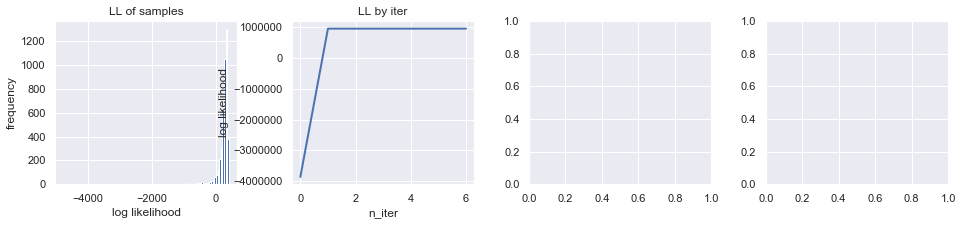

In [82]:
display_pca_data(n_components, decomp, BES_std)

Warning, filename truncated because it was over 30. Filenames may no longer be unique


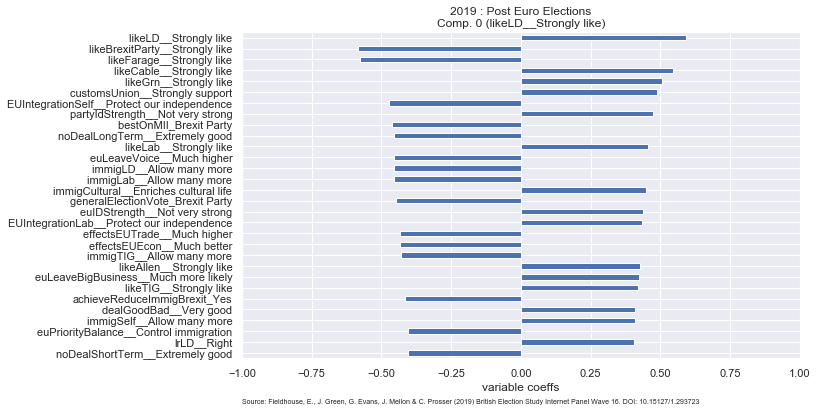

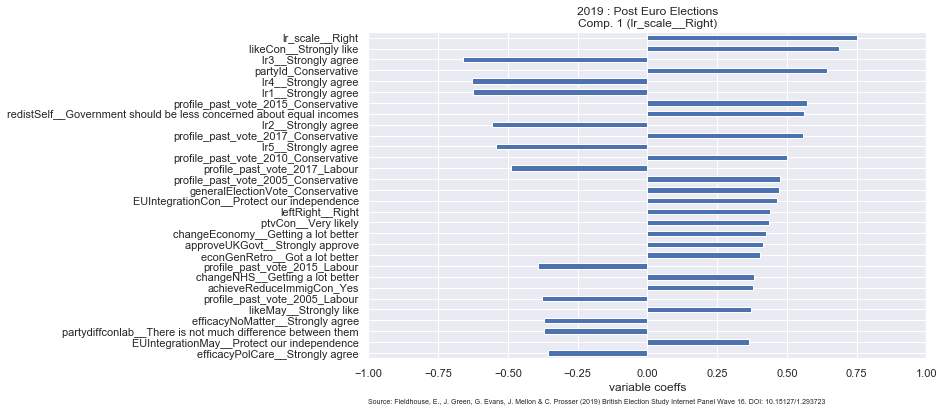

In [83]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df_cols, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [58]:
search(BES_reduced,"country")

automationEffectsCountry__Very good                                               37959
country_England                                                                   37959
countryOfBirth_England                                                            37959
countryOfBirth_Scotland                                                           37959
countryOfBirth_Wales                                                              37959
countryOfBirth_Other: Rest of world                                               37959
countryOfBirth_Other: European Union member country                               37959
countryOfBirth_Other: Commonwealth member country                                 37959
countryOfBirth_Northern Ireland                                                   37959
countryOfBirth_Republic of Ireland                                                37959
profile_scotref_vote_I voted 'Yes' (Scotland should be an independent country)    37959
dtype: int64

In [49]:
BES_Panel.shape, BES_reduced.shape

((37959, 469), (9243, 656))

In [79]:
BES_Panel["likeSturgeon"][BES_Panel["euroElectionBXPVoter"]=="Yes"].value_counts(dropna=False)

NaN                 8723
Strongly dislike     367
1                     31
5                     26
3                     24
2                     20
7                     11
4                     11
8                      8
6                      8
9                      6
Don't know             4
Strongly like          4
Name: likeSturgeon, dtype: int64

In [64]:
df["approveScotGovt__Strongly approve"].value_counts()

2    4377
0       7
1       2
Name: approveScotGovt__Strongly approve, dtype: int64

In [61]:
df["gor_Scotland"].value_counts(), df.shape

(0    4376
 1      10
 Name: gor_Scotland, dtype: int64, (4386, 656))

In [76]:
df["likeSturgeon__Strongly like"].value_counts()

5    4377
0       8
4       1
Name: likeSturgeon__Strongly like, dtype: int64

In [43]:
df[].value_counts()

KeyError: 'country'